<a href="https://colab.research.google.com/github/rajdeepbanerjee-git/JNCLectures_Intro_to_ML/blob/main/Week10/Week10_cost_complexity_pruning_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cost-Complexity Pruning (Weakest Link Pruning)

When a decision tree is grown to full depth, it may overfit the training data. **Cost-complexity pruning** (also known as weakest link pruning) is a method used to reduce overfitting by balancing the tree’s complexity and its training error.

The cost-complexity measure is defined as:

$$
R_\alpha(T) = R(T) + \alpha \, |T|
$$

where:

- $R(T)$ is the training error (or impurity) of the tree $T$. In classification, this can be the misclassification rate or the sum of impurity measures (e.g., Gini or entropy) at the leaves.
- $|T|$ is the number of terminal nodes (leaves) in the tree.
- $\alpha \ge 0 $ is the complexity parameter that penalizes the number of leaves.

**Interpretation:**

- When $\alpha = 0$, there is no penalty for complexity, so the fully grown tree is chosen.
- As $\alpha$ increases, the penalty for complexity becomes more significant. The algorithm then seeks a subtree $ T_\alpha$ that minimizes $R_\alpha(T)$.

### Obtaining the Pruning Path

The pruning path is a sequence of subtrees obtained by iteratively removing the branch (or node) that contributes the least to reducing the error per leaf removed. For each candidate node, we compute the ratio:

$$
\alpha_{\text{node}} = \frac{R(\text{node before pruning}) - R(\text{node after pruning})}{\Delta |T|}
$$

- $R(\text{node before pruning})$ is the training error of the subtree rooted at that node.
- $R(\text{node after pruning})$ is the training error after replacing that subtree with a leaf.
- $\Delta |T|$ is the reduction in the number of leaves (usually 1).

The node with the smallest $\alpha_{\text{node}}$ is pruned first. This process generates a sequence of $\alpha$ values (denoted as `ccp_alphas` in scikit-learn) corresponding to subtrees with different complexities. The goal is then to use cross-validation to choose the best $\alpha$ value that minimizes the expected error on unseen data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# 1. Load the Breast Cancer Dataset and Split Data
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


In [10]:
# 2. Train a Fully Grown (Unpruned) Tree
clf_unpruned = DecisionTreeClassifier(random_state=42)
clf_unpruned.fit(X_train, y_train)
print("Unpruned Tree Train Accuracy:", clf_unpruned.score(X_train, y_train))
print("Unpruned Tree Test Accuracy:", clf_unpruned.score(X_test, y_test))


Unpruned Tree Train Accuracy: 1.0
Unpruned Tree Test Accuracy: 0.9230769230769231


In [4]:
# 3. Obtain the Cost-Complexity Pruning Path
# The cost_complexity_pruning_path method computes a sequence of effective alpha values and corresponding total impurities.
path = clf_unpruned.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print("Effective alphas from pruning path:", ccp_alphas)


Effective alphas from pruning path: [0.         0.00231936 0.00312989 0.00422535 0.00456509 0.00532081
 0.0056338  0.00633803 0.00814228 0.01487676 0.02166662 0.05466684
 0.32538187]


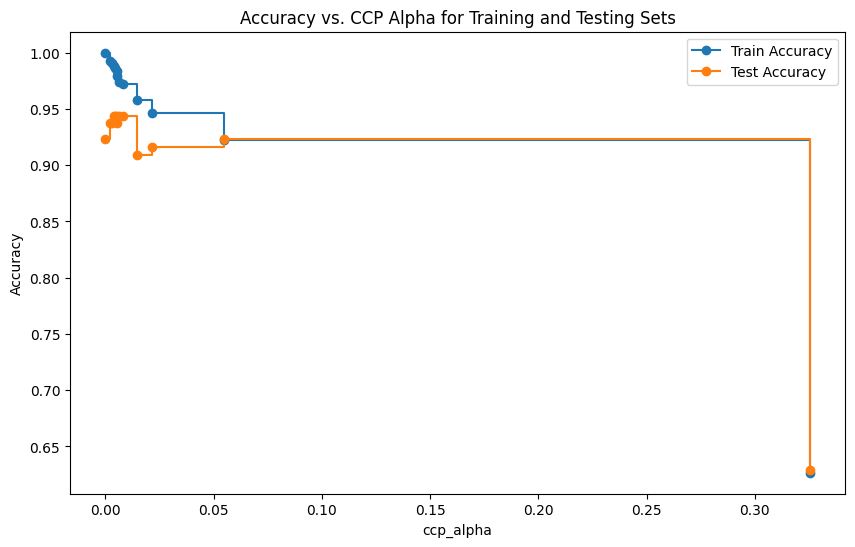

In [5]:
# 4. Train a Tree for Each Value of ccp_alpha and Record Scores
clfs = []
train_scores = []
test_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

# Plot training and test accuracy vs. ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="Test Accuracy", drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. CCP Alpha for Training and Testing Sets")
plt.legend()
plt.show()


In [6]:
# 5. Choose the Best Alpha Using Cross-Validation
param_grid = {"ccp_alpha": ccp_alphas}
clf_for_cv = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf_for_cv, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_["ccp_alpha"]
print("Best alpha from cross-validation:", best_alpha)
print("Best cross-validated score:", grid_search.best_score_)

Best alpha from cross-validation: 0.0031298904538341154
Best cross-validated score: 0.9390697674418605


In [8]:
# 6. Train Final Classifier with the Best Alpha and Evaluate on Test Set
clf_final = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_final.fit(X_train, y_train)
final_test_accuracy = clf_final.score(X_test, y_test)
final_train_accuracy = clf_final.score(X_train, y_train)
print("Final Train Accuracy with Best Alpha:", final_train_accuracy)
print("Final Test Accuracy with Best Alpha:", final_test_accuracy)

Final Train Accuracy with Best Alpha: 0.9906103286384976
Final Test Accuracy with Best Alpha: 0.9370629370629371
